### Import trained model
Run `nvidia-smi -l 1` to check the memory being used by what.
You will need to restart the kernel if the program is crashing as jupyter stays allive and keeps the data in the memory.

In [1]:
import pickle
import keras
import librosa
import librosa.display
import numpy as np
from sklearn import metrics
import tensorflow as tf
from keras.models import load_model

#sound_model_file = "sound_model.pkl"
label_encoder_file = "labelencoder.pkl"


model = None

model = load_model('sound_category_model.h5')

#with open(sound_model_file, 'rb') as file:
#    model = pickle.load(file)

with open(label_encoder_file, 'rb') as file:
    le = pickle.load(file)

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
#%store -r model 
#%store -r le
%store -r X
%store -r y

Using TensorFlow backend.


In [2]:
usl = "../resources/UrbanSound8K/"

In [3]:

num_rows = 40
num_columns = 174
num_channels = 1

max_pad_len = 174

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

7980/7980 [==============================] - 1s 148us/step
Training Accuracy:  0.984085202217102
1996/1996 [==============================] - 0s 58us/step
Testing Accuracy:  0.9579158425331116


In [4]:
def prediction(file_name, print_data = False):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    if print_data:
        print("The predicted class is:", predicted_class[0], '\n') 
        
        for i in range(len(predicted_proba)): 
            category = le.inverse_transform(np.array([i]))
            print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )
    return (predicted_class[0], format(predicted_proba[predicted_vector[0]] * 100, '.32f'))

In [5]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name, e)
        return None 
     
    return mfccs

In [6]:
# Class: Air Conditioner

filename = usl + 'audio/fold5/100852-0-0-0.wav' 
prediction(filename, True) 

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99914872646331787109375000000000
car_horn 		 :  0.00000000001802147320262292851112
children_playing 		 :  0.00054140144493430852890014648438
dog_bark 		 :  0.00000074677274142231908626854420
door_bell 		 :  0.00000000000000000000000000004295
drilling 		 :  0.00015402764256577938795089721680
engine_idling 		 :  0.00000113216412955807754769921303
fire_alarm 		 :  0.00000000000000000000007302906336
jackhammer 		 :  0.00005318045077729038894176483154
music 		 :  0.00000000000000024660104297799914
person_talking 		 :  0.00000000000000000000000019784195
shuffling 		 :  0.00000000000000000000000196146734
siren 		 :  0.00000000602197980370533514360432
street_music 		 :  0.00010069543350255116820335388184


('air_conditioner', '99.91487264633178710937500000000000')

In [7]:
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

### Checking data from testing for more info

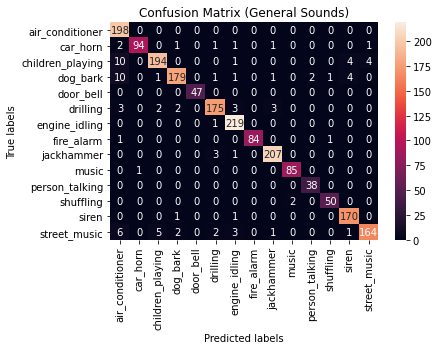

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = le.classes_

plt.figure()
ax= plt.subplot(111)
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (General Sounds)')
ax.xaxis.set_ticklabels(label_names, rotation='vertical');
ax.yaxis.set_ticklabels(label_names, rotation='horizontal');

plt.savefig('confusion_matrix.png', bbox_inches='tight')

plt.show()

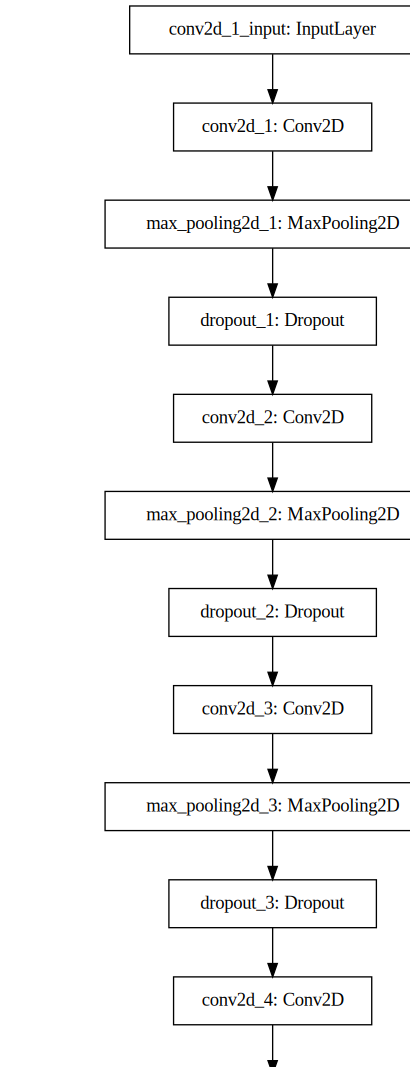

In [9]:
from IPython.display import SVG
from keras.utils import model_to_dot

# The output is a bit dodgy so you need to change the viewport value to
# width="550" height="1467" viewBox="0.00 0.00 550.00 1467.00"
with open("model_graph.svg", 'wb') as file:
    file.write(model_to_dot(model).create(prog='dot', format='svg'))
    
SVG("model_graph.svg")

### Test with sounds from odas

In [10]:
from os import listdir
from os.path import isfile, join

odas_clips = "/home/sekwah/Music/"

sound_files = [f for f in listdir(odas_clips) if isfile(join(odas_clips, f))]

#print(sound_files)

for file in sound_files:
    try:
        predict = prediction(join(odas_clips, file), False)
        print("{} {}% {}".format(predict[0], predict[1], file))
    except:
        print("Error reading file: " + join(odas_clips, file))

music 99.95131492614746093750000000000000% ODAS_462_2020-5-12_0-31-26-976_45_pf.wav
car_horn 63.21774721145629882812500000000000% ODAS_462_2020-5-12_0-31-26-976_50_pf.wav
music 99.98550415039062500000000000000000% ODAS_462_2020-5-12_0-31-26-976_26_pf.wav
music 98.06599020957946777343750000000000% ODAS_462_2020-5-12_0-31-26-976_4_pf.wav
music 88.16573023796081542968750000000000% ODAS_462_2020-5-12_0-31-26-976_8_pf.wav
music 66.01036787033081054687500000000000% ODAS_462_2020-5-12_0-31-26-976_16_pf.wav
music 99.39564466476440429687500000000000% ODAS_462_2020-5-12_0-31-26-976_37_pf.wav
music 99.34141635894775390625000000000000% ODAS_462_2020-5-12_0-31-26-976_18_pf.wav
music 99.91776347160339355468750000000000% ODAS_462_2020-5-12_0-31-26-976_33_pf.wav
music 99.14278388023376464843750000000000% ODAS_462_2020-5-12_0-31-26-976_48_pf.wav
music 99.56747889518737792968750000000000% ODAS_462_2020-5-12_0-31-26-976_3_pf.wav
music 98.00614714622497558593750000000000% ODAS_462_2020-5-12_0-31-26-976_47